In [136]:
import json
import scipy
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from typing import Callable, Sequence
from PIL import Image
from tqdm import tqdm
from utils import tensor_to_pil

In [2]:
dataset_dir = "../datasets/flowers_2/"

First we will convert the image file into a tensor

In [3]:
def transforms():
    """ 
    ToTensor: 
        Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
        to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

    Resize:
        Resize the input image to the given size. 
        If the image is torch Tensor, it is expected to have […, H, W] shape
    """
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((64, 64), interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR),
        torchvision.transforms.ToTensor(),
    ])

In [137]:
train_dataset = torchvision.datasets.Flowers102(dataset_dir, split="train", transform=transforms(), download=False)
valid_dataset = torchvision.datasets.Flowers102(dataset_dir, split="val", transform=transforms(), download=False)
test_dataset = torchvision.datasets.Flowers102(dataset_dir, split="test", transform=transforms(), download=False)

In [5]:
len(train_dataset), len(valid_dataset), len(test_dataset), 

(1020, 1020, 6149)

In [7]:
def linear_diffusion_schedule(beta_min: float, beta_max: float, diffusion_times: list[float]) -> list[float]:
    """ Returns the alpha bar values at different time steps based on a linearly increasing schedule """
    betas = beta_min + diffusion_times * (beta_max - beta_min)
    alphas = 1 - betas
    return np.cumprod(alphas)

In [8]:
def quadratic_diffusion_schedule(beta_min: float, beta_max: float, diffusion_times: list[float]) -> list[float]:
    """ Returns the alpha bar values at different time steps based on a quadratic increasing schedule """
    betas = beta_min + (diffusion_times ** 2) * (beta_max - beta_min)
    alphas = 1 - betas
    return np.cumprod(alphas)

In [9]:
def cosine_diffusion_schedule(diffusion_times: list[float]) -> list[float]:
    """ Returns the alpha bar values at different time steps using sinusoid schedule."""
    return np.cos(diffusion_times * (np.pi / 2)) ** 2

In [10]:
def offset_cosine_diffusion_schedule(min_rate: float, max_rate: float, diffusion_times: list[float]) -> list[float]:
    """ Returns the alpha bar values at different time steps using sinusoid schedule."""
    start_angle = np.acos(max_rate)
    end_angle = np.acos(min_rate)
    angles = start_angle + diffusion_times * (end_angle - start_angle)
    return np.cos(angles) ** 2

Text(0.5, 1.0, 'noise')

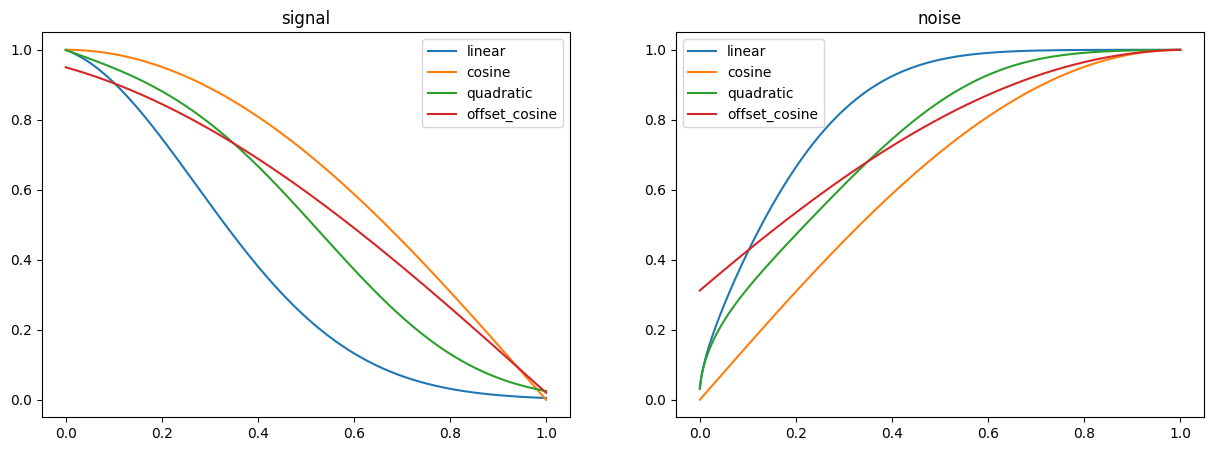

In [11]:
steps = 1000
diffusion_times = np.linspace(0.0, 1.0, num=steps)
linrates = linear_diffusion_schedule(0.001, 0.02, diffusion_times)
cosrates = cosine_diffusion_schedule(diffusion_times)
quadratic = quadratic_diffusion_schedule(0.001, 0.02, diffusion_times)
offset = offset_cosine_diffusion_schedule(0.02, 0.95, diffusion_times)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(np.linspace(0, 1, steps), np.sqrt(linrates), label="linear")
ax1.plot(np.linspace(0, 1, steps), np.sqrt(cosrates), label="cosine")
ax1.plot(np.linspace(0, 1, steps), np.sqrt(quadratic), label="quadratic")
ax1.plot(np.linspace(0, 1, steps), np.sqrt(offset), label="offset_cosine")
ax1.legend()
ax1.set_title("signal")

ax2.plot(np.linspace(0, 1, steps), np.sqrt(1 - linrates), label="linear")
ax2.plot(np.linspace(0, 1, steps), np.sqrt(1 - cosrates), label="cosine")
ax2.plot(np.linspace(0, 1, steps), np.sqrt(1 - quadratic), label="quadratic")
ax2.plot(np.linspace(0, 1, steps), np.sqrt(1 - offset), label="offset_cosine")
ax2.legend()
ax2.set_title("noise")

In [12]:
def image_corruption(
    input_image: torch.Tensor, 
    max_steps: int,
    schedule: Callable[list[float], list[float]]
) -> torch.Tensor:
    """ Returns image corrupted at different time steps """
    diffusion_times = np.linspace(0.0, 1.0, num=max_steps)
    alpha_bars = torch.Tensor(schedule(diffusion_times)).view(max_steps, 1, 1, 1)
    input_repeated = input_image.repeat((max_steps, 1, 1, 1))
    gaussian_noise = torch.randn((max_steps, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
    images = torch.sqrt(alpha_bars) * input_repeated + torch.sqrt(1 - alpha_bars) * gaussian_noise
    return torch.cat((torch.unsqueeze(input_image, 0), images))

In [1]:
steps = 1000
linear_corrupted = image_corruption(test_batch_data[0], steps, lambda s: linear_diffusion_schedule(0.0001, 0.02, s))
quadratic_corrupted = image_corruption(test_batch_data[0], steps, lambda s: quadratic_diffusion_schedule(0.0001, 0.02, s))
cosine_corrupted = image_corruption(test_batch_data[0], steps, lambda s: cosine_diffusion_schedule(s))
f, ax = plt.subplots(3, int(steps / 100), sharey=True, figsize=(20, 5))
for i in range(len(ax[0])):
    img = linear_corrupted[i * 100]
    ax[0][i].imshow(tensor_to_pil(img))
    ax[0][i].axis("off")

    img = quadratic_corrupted[i * 100]
    ax[1][i].imshow(tensor_to_pil(img))
    ax[1][i].axis("off")

    img = cosine_corrupted[i * 100]
    ax[2][i].imshow(tensor_to_pil(img))
    ax[2][i].axis("off")

    
f.tight_layout(pad=0, h_pad=0, w_pad=0)

NameError: name 'image_corruption' is not defined

# Model Definition

In [83]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, embedding_dim: int, theta: int):
        super().__init__()
        self.dims = embedding_dim
        self.theta = theta

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Takes in a 1-D tensor of noise variance with shape (batch size,) """
        
        half_dim = self.dims // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=x.device) * -emb)
        emb = x[:, None] * emb[None, :]
        
        # Embeddings shape: (batch size, dims)
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

In [2]:
embedding_layer = SinusoidalPositionEmbeddings(128, 10000)
data = np.arange(0, 500, 1)
emb = embedding_layer(torch.tensor(data, dtype=torch.float))
plt.figure(figsize=(15, 30))
plt.imshow(emb.T)

NameError: name 'SinusoidalPositionEmbeddings' is not defined

In [16]:
class ResidualBlock(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        time_emb_dim: int, 
        num_groups: int, 
        kernel_size: int = 3,
        dropout: float = 0,
        use_attention: bool = False
    ):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.act1 = nn.SiLU()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding="same")

        self.time_act = nn.SiLU()
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.act2 = nn.SiLU()
        self.dropout = nn.Dropout(dropout)

        # The residual conv blocks don't change the input channels
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding="same")
        self.residual = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)
        self.attention = SelfAttention(out_channels, num_groups) if use_attention else nn.Identity()

    def forward(self, x, time_emb):
        # First part
        x_init = x
        x = self.norm1(x)
        x = self.act1(x)
        x = self.conv1(x)
        
        # Add time embedding
        time_emb = self.time_mlp(self.time_act(time_emb))[:, :, None, None]  # Reshape for broadcasting
        x = x + time_emb
        
        # Second part
        x = self.norm2(x)
        x = self.act2(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.attention(x)
        
        return x + self.residual(x_init)

In [17]:
class Downsample(nn.Module):
    def __init__(self, channels:int, use_conv: bool = True):
        super().__init__()
        if use_conv:
            self.down = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.down = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.down(x)

In [18]:
class Upsample(nn.Module):
    def __init__(self, channels:int, use_conv: bool = True):
        super().__init__()
        if use_conv:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
            )
        else:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.up(x)

In [19]:
class SelfAttention(nn.Module):
    def __init__(self, channels: int, num_groups: int):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.out = nn.Conv2d(channels, channels, 1)
        
    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        
        # Get queries, keys, values
        qkv = self.qkv(x_norm).reshape(b, 3, c, h * w)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]
        
        # Compute attention (corrected einsum for 3D tensors)
        attn = torch.einsum('bcl,bcs->bls', q, k) / math.sqrt(c)
        attn = F.softmax(attn, dim=-1)
        
        # Apply attention to values
        out = torch.einsum('bls,bcs->bcl', attn, v).reshape(b, c, h, w)
        
        return self.out(out) + x

In [131]:
class DiffusionUNet(nn.Module):
    def __init__(
        self, 
        in_channels: int,
        out_channels: int,
        base_channels: int,
        image_resolution: int,
        num_res_blocks:int,
        channel_multipliers: list[int],
        attention_resolutions: list[int],
        resample_with_conv: bool,
        time_emb_dim: int,
        dropout: float
    ):
        super().__init__()

        group_norm_groups = 32
        theta = 10000
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim, theta),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )
        self.conv_in = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.down_blocks = nn.ModuleList()
        self.middle_blocks = None
        self.up_blocks = nn.ModuleList()

        resolution = image_resolution  # image H x W

        # Downblocks
        downchannels = [base_channels]  # store down channels for skip connections
        
        # Number of resolutions equal to channel multipliers
        in_channels = base_channels
        for i, multiplier in enumerate(channel_multipliers):
            curr_channels = multiplier * base_channels
            for n in range(num_res_blocks):
                self.down_blocks.append(
                    ResidualBlock(
                        in_channels=in_channels,
                        out_channels=curr_channels, 
                        time_emb_dim=time_emb_dim, 
                        num_groups=group_norm_groups, 
                        dropout=dropout,
                        use_attention=(resolution in attention_resolutions),
                    )
                )
                downchannels.append(curr_channels)
                in_channels = curr_channels

            # Don't downsample on final block
            if i != len(channel_multipliers) - 1:
                self.down_blocks.append(
                    Downsample(curr_channels, use_conv=resample_with_conv)
                )
                downchannels.append(curr_channels)
                resolution = resolution // 2

        self.middle_blocks = nn.ModuleList([
            ResidualBlock(curr_channels, curr_channels, time_emb_dim, group_norm_groups, dropout=dropout, use_attention=True),
            ResidualBlock(curr_channels, curr_channels, time_emb_dim, group_norm_groups, dropout=dropout)
        ])

        # Upblocks
        in_channels = curr_channels
        resolution = image_resolution // (2 ** len(channel_multipliers))
        for i, multiplier in enumerate(reversed(channel_multipliers)):
            curr_channels = multiplier * base_channels
            for _ in range(num_res_blocks + 1):
                skip = downchannels.pop()
                combined_channels = skip + in_channels
                self.up_blocks.append(
                    # Concatenate input with skip connections
                    ResidualBlock(
                        in_channels=combined_channels,
                        out_channels=curr_channels,
                        time_emb_dim=time_emb_dim,
                        num_groups=group_norm_groups,
                        dropout=dropout,
                        use_attention=(resolution in attention_resolutions)
                    )
                )
                in_channels = curr_channels

            # Don't Upsample on final block
            if i != len(channel_multipliers) - 1:
                self.up_blocks.append(Upsample(curr_channels, use_conv=resample_with_conv))
                resolution = resolution * 2

        self.final_group = nn.GroupNorm(group_norm_groups, curr_channels)
        self.final_act = nn.SiLU()
        self.conv_out = nn.Conv2d(curr_channels, out_channels, kernel_size=3, padding=1)
            
    def forward(self, x: torch.Tensor, noise_variances: torch.Tensor) -> torch.Tensor:
        time_embs = self.time_embedding(noise_variances)
        x = self.conv_in(x)

        down_outputs = [x]
        for i, layer in enumerate(self.down_blocks):
            if isinstance(layer, ResidualBlock):
                x = layer(x, time_embs)
            else:
                x = layer(x)

            down_outputs.append(x)

        for i, layer in enumerate(self.middle_blocks):
            x = layer(x, time_embs)

        for i, layer in enumerate(self.up_blocks):
            if isinstance(layer, ResidualBlock):
                skip = down_outputs.pop()
                x = torch.concat((x, skip), dim=1) # concatenate on channels
                x = layer(x, time_embs)
            else:
                x = layer(x)

        x = self.final_group(x)
        x = self.final_act(x)
        x = self.conv_out(x)
        return x

In [132]:
model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)   

In [133]:
print(model)

DiffusionUNet(
  (time_embedding): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): SiLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0-1): 2 x ResidualBlock(
      (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
      (act1): SiLU()
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (time_act): SiLU()
      (time_mlp): Linear(in_features=128, out_features=32, bias=True)
      (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
      (act2): SiLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (residual): Identity()
      (attention): Identity()
    )
    (2): Downsample(
      (down): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    

In [134]:
batch_size = 4
x = torch.randn(batch_size, 3, 64, 64)
t = torch.randn((batch_size,))

print("input", x.shape, "noise shape", t.shape)
y = model(x, t)
print("output", y.shape)

input torch.Size([4, 3, 64, 64]) noise shape torch.Size([4])
output torch.Size([4, 3, 64, 64])


## Training

In [223]:
epochs = 10
batch_size = 4
diffusion_model = model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)
optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=0.001, weight_decay=1e-4)
min_rate = 0.02
max_rate = 0.95
timesteps = 1000
alpha_bars = offset_cosine_diffusion_schedule(min_rate, max_rate, np.arange(timesteps))
signal_rates = torch.tensor(np.sqrt(alpha_bars), dtype=torch.float)
noise_rates = torch.tensor(np.sqrt(1 - alpha_bars), dtype=torch.float)

In [224]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [225]:
train_dataloader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [246]:
# Training Loop
model.train()
batch = train_dataset[0][0].unsqueeze(0).repeat(batch_size, 1, 1, 1)
for e in range(epochs):
    total_loss = 0
    with tqdm(train_dataloader) as pbar:
        for batch_idx, (batch_images, batch_labels) in enumerate(pbar):
            optimizer.zero_grad()
            batch_images = batch

            # Sample timesteps and reshape to have shape (batch size, 1, 1, 1) for broadcasting
            sampled_timesteps = torch.randint(timesteps, (batch_size,))
            timesteps_signal_rate = signal_rates[sampled_timesteps].view(-1, 1, 1, 1)
            timestep_noise_rate = noise_rates[sampled_timesteps].view(-1, 1, 1, 1)
            # print(timesteps_signal_rate.shape, timestep_noise_rate.shape, batch_images.shape)
            # print(timesteps_signal_rate.dtype, timestep_noise_rate.dtype, batch_images.dtype)
            
            # noise
            noise = torch.randn_like(batch_images)
            noisy_images = timesteps_signal_rate * batch_images + timestep_noise_rate * noise

            predicted_noise = model(noisy_images, sampled_timesteps)

            loss = F.mse_loss(predicted_noise, noise)
            loss.backward()

            # Gradient debugging - check for NaNs and large gradients
            max_grad = 0
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any():
                        print(f"NaN gradient in {name}")
                    max_grad = max(max_grad, param.grad.abs().max().item())


            optimizer.step()    
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item(), max_grad=max_grad)

            # if batch_idx > 5:
            #     break

    print(f'Epoch {i+1} | Average Loss {total_loss / (batch_idx + 1):.5f}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:39<00:00,  2.56it/s, loss=0.00814, max_grad=0.0164]


Epoch 1 | Average Loss 0.01857


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:46<00:00,  2.40it/s, loss=0.00418, max_grad=0.00749]


Epoch 1 | Average Loss 0.02056


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [01:43<00:00,  2.47it/s, loss=0.00854, max_grad=0.0171]


Epoch 1 | Average Loss 0.01852


  4%|████▊                                                                                                                                    | 9/255 [00:03<01:49,  2.25it/s, loss=0.0504, max_grad=0.0129]


KeyboardInterrupt: 

In [247]:
# Sampling
# 6. Visualization - generate a sample after each epoch
model.eval()
with torch.no_grad():
    # Start with random noise
    x = torch.randn(1, 3, 64, 64)
    
    # Reverse diffusion process (simplified using DDIM)
    for i in tqdm(reversed(range(0, timesteps)), desc="Sampling"):
        t_batch = torch.tensor([i])
        noise_level = noise_rates[t_batch].view(-1, 1, 1, 1)
        signal_level = signal_rates[t_batch].view(-1, 1, 1, 1)
        # print(t_batch, signal_level, noise_level)
        
        # Only predict and denoise a few timesteps for speed
        predicted_noise = model(x, t_batch)
        pred_images = (x - noise_level * predicted_noise) / signal_level

        if i > 0:
            next_signal_rate = signal_rates[i-1]
            next_noise_rate = noise_rates[i-1]
            x = next_signal_rate * pred_images + next_noise_rate * predicted_noise
        else:
            x = pred_images

    # Normalize to [0, 1] range for display
    x = (x.clamp(-1, 1) + 1) / 2

# plt.figure(figsize=(4, 4))
# img = x[0].cpu().permute(1, 2, 0).clip(0, 1).numpy()
# plt.imshow(img)
# # plt.title(f"Sample after epoch {epoch+1}")
# plt.axis('off')
# plt.savefig(f"sample_epoch_{epoch+1}.png")
# plt.close()

Sampling: 1000it [00:31, 31.46it/s]


In [3]:
plt.figure()
img = x[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')

NameError: name 'plt' is not defined

In [4]:
plt.figure()
img = batch[3].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')

NameError: name 'plt' is not defined